# Adding Boundary Pores

In this example we will illustrate how boundary pores are added during the network extraction phase.  We will use the individual steps of the SNOW algorithm (i.e. ``porespy.filters.snow_partioning``), rather than use the pre-packaged ``porespy.networks.snow`` function.

In [1]:
import porespy as ps
import matplotlib.pyplot as plt
import numpy as np
import openpnm as op
from edt import edt
from copy import copy

Start by creating a 2D image of lattice spheres, to keep things very simple:

------------------------------------------------------------
lattice_spheres: Generating sc lattice


<AxesSubplot:>

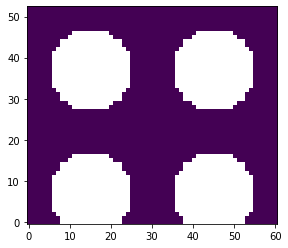

In [2]:
im = ps.generators.lattice_spheres(shape=[51, 51], radius=10, offset=5)
im = np.pad(im, [[0, 5], [5, 5]], constant_values=1)[3:, ...]
ps.imshow(im)

------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  9
Peaks after trimming saddle points:  9
Peaks after trimming nearby peaks:  9


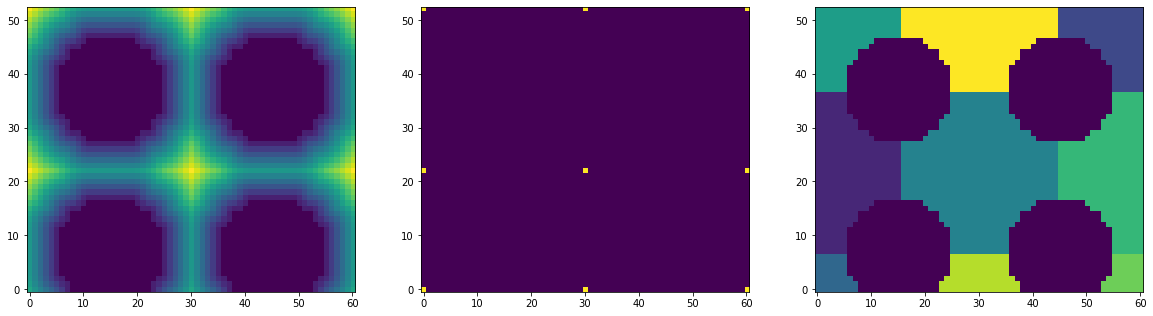

In [3]:
snow = ps.filters.snow_partitioning(im, return_all=True)
fig, ax = plt.subplots(1, 3, figsize=[20, 30])
ax[0].imshow(snow.dt, origin='lower', interpolation='none')
ax[1].imshow(snow.peaks > 0, origin='lower', interpolation='none')
ax[2].imshow(snow.regions, origin='lower', interpolation='none')

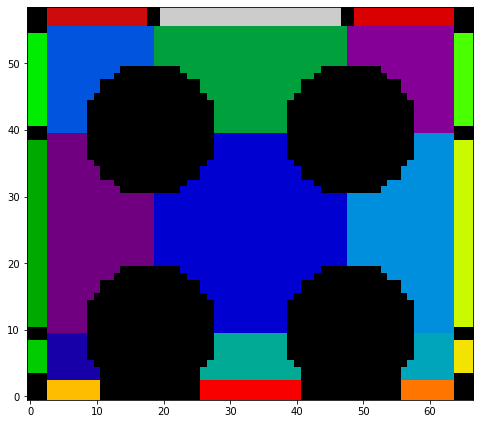

In [4]:
bds = ps.networks.add_boundary_regions(regions=snow.regions, faces=['front', 'back', 'left', 'right'])
cm = copy(plt.cm.nipy_spectral)
plt.figure(figsize=[8, 8])
plt.imshow(bds, origin='lower', interpolation='none', cmap=cm)

The image above shows how boundary regions appear.  They are 3-voxel thick slices that are padded onto each face and given a unique label to differentiate them from the internal pores to which they connect. There are a few key things to note:

* Boundary regions that touch each other are separated by a small solid obstacle indicated by black.  This is to prevent boundary pores from becoming connected to each other when the network extraction function is applied (``regions_to_network``).
* Corners are also converted to solid obstacles.  This is for the same reason as above, but also because it's not clear which internal pores these corners should be connected to. 
* A thickness of 3 voxels was chosen since this was necessary for the ``marching_cubes`` surface area calculation.  It is also a good idea for the pore centroid to be padded by 1-voxel on each side. This 3-voxel dimension can pose problems during the network extraction stage since most of the physical dimensions will be meaningless.  Consequently care must be taken to ensure that these boundary pores are treated correctly. In many cases it may be preferrable to forego the them entirely and just apply boundary conditions on real pores lying on the domain surface.

Passing this image into the ``regions_to_network`` function will treat each region as an actual pore:

In [5]:
net = ps.networks.regions_to_network(bds)

------------------------------------------------------------
Extracting pore and throat information from image
100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 626.14it/s]


(-0.5, 58.5, -0.5, 66.5)

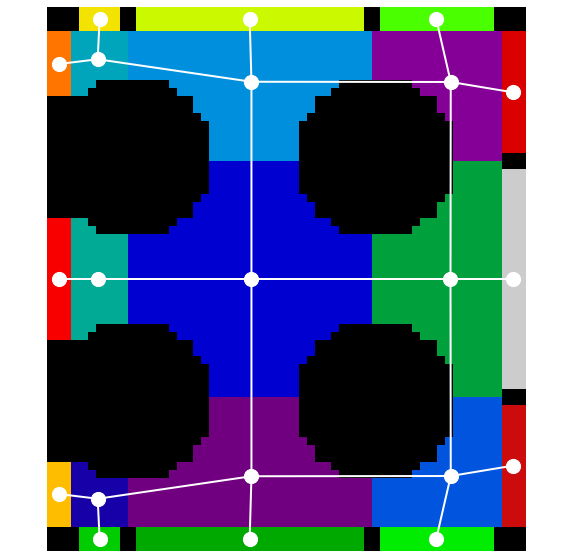

In [6]:
pn, geo = op.io.PoreSpy.import_data(net)
fig = plt.figure(figsize=[10, 10])
fig = op.topotools.plot_connections(pn, c='w', linewidth=2, fig=fig)
fig = op.topotools.plot_coordinates(pn, c='w', s=200, fig=fig)
plt.imshow(bds.T, cmap=cm, origin='lower')
plt.axis('off')

The approach outlined above is missing one important feature.  The boundary pores are not labelled.  When the process is performed internally by the ``regions_to_network`` function this is taken care of.  

In [7]:
print(pn)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.network.GenericNetwork : net_01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.coords                                      21 / 21   
2     throat.conns                                     22 / 22   
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Labels                                        Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.all                                      21        
2     pore.geo_01                                   21        
3     throat.all                                    22        
4     throat.geo_01                                 22        
―――――――――――――――――――――――――――――――――――――――――――――